conda install pandas numpy matplotlib seaborn requests bs4

In [3]:
# Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Settings to produce nice plots in a Jupyter notebook
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns

# To extract and parse fundamental data from finviz website
import requests
from bs4 import BeautifulSoup as bs

# For parsing financial statements data from financialmodelingprep api
from urllib.request import urlopen
import json
def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

# Financialmodelingprep api url
base_url = "https://financialmodelingprep.com/api/v3/"

In [4]:
apiKey = 'a2fade86926c0fd50df3ebc5c2159a76'

In [101]:
ticker = "DAC"

In [168]:
company = 'AEO'
demo = apiKey
IS = requests.get(f'https://financialmodelingprep.com/api/v3/income-statement/{company}?apikey={demo}').json()
count = 0
#get revenue growth to estimate future sales
revenue_g = []
for item in IS:
  if count < 4:
    #print(item)
    revenue_g.append(item['revenue'])
    count = count + 1

revenue_g = (revenue_g[0] - revenue_g[1]) /revenue_g[1] 
print(revenue_g)

0.06752004598931541


In [169]:
#Get net income
net_income = IS[0]['netIncome']

BS = requests.get(f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{company}?apikey={demo}').json()

#get income statement as % of revenue for future predictions and forecast 5 next IS years
income_statement = pd.DataFrame.from_dict(IS[0],orient='index')
#The [5:26] below get rids of not needed items coming from the API
income_statement = income_statement[6:27]
income_statement.columns = ['current_year']
income_statement['as_%_of_revenue'] = income_statement / income_statement.iloc[0]


In [170]:
#forecasting 5 next years income statement
income_statement['next_year'] =  (income_statement['current_year']['revenue'] * (1+revenue_g)) * income_statement['as_%_of_revenue'] 
income_statement['next_2_year'] =  (income_statement['next_year']['revenue'] * (1+revenue_g)) * income_statement['as_%_of_revenue'] 
income_statement['next_3_year'] =  (income_statement['next_2_year']['revenue'] * (1+revenue_g)) * income_statement['as_%_of_revenue'] 
income_statement['next_4_year'] =  (income_statement['next_3_year']['revenue'] * (1+revenue_g)) * income_statement['as_%_of_revenue'] 
income_statement['next_5_year'] =  (income_statement['next_4_year']['revenue'] * (1+revenue_g)) * income_statement['as_%_of_revenue'] 

#Get Balance sheet as a percentage of revenue
balance_sheet = pd.DataFrame.from_dict(BS[0],orient='index')
balance_sheet = balance_sheet[6:-3]
balance_sheet.columns = ['current_year']
balance_sheet['as_%_of_revenue'] = balance_sheet / income_statement['current_year'].iloc[0]

#forecasting the next 5 years Balance Sheet.
balance_sheet['next_year'] =  income_statement['next_year'] ['revenue'] * balance_sheet['as_%_of_revenue']
balance_sheet['next_2_year'] =  income_statement['next_2_year'] ['revenue'] * balance_sheet['as_%_of_revenue']
balance_sheet['next_3_year'] =  income_statement['next_3_year']['revenue'] * balance_sheet['as_%_of_revenue'] 
balance_sheet['next_4_year'] =  income_statement['next_4_year']['revenue']  * balance_sheet['as_%_of_revenue'] 
balance_sheet['next_5_year'] =  income_statement['next_5_year']['revenue'] * balance_sheet['as_%_of_revenue']

In [171]:
CF_forecast = {}
CF_forecast['next_year'] = {}
CF_forecast['next_year']['netIncome'] = income_statement['next_year']['netIncome']
CF_forecast['next_year']['inc_depreciation'] = income_statement['next_year']['depreciationAndAmortization']
CF_forecast['next_year']['inc_receivables'] = balance_sheet['next_year']['netReceivables'] - balance_sheet['current_year']['netReceivables']
CF_forecast['next_year']['inc_inventory'] = balance_sheet['next_year']['inventory'] - balance_sheet['current_year']['inventory']
CF_forecast['next_year']['inc_payables'] = balance_sheet['next_year']['accountPayables'] - balance_sheet['current_year']['accountPayables']
CF_forecast['next_year']['CF_operations'] = CF_forecast['next_year']['netIncome'] + CF_forecast['next_year']['inc_depreciation'] + (CF_forecast['next_year']['inc_receivables'] * -1) + (CF_forecast['next_year']['inc_inventory'] *-1) + CF_forecast['next_year']['inc_payables']
CF_forecast['next_year']['CAPEX'] = balance_sheet['next_year']['propertyPlantEquipmentNet'] - balance_sheet['current_year']['propertyPlantEquipmentNet'] + income_statement['next_year']['depreciationAndAmortization']

CF_forecast['next_year']['FCF'] = CF_forecast['next_year']['CAPEX'] + CF_forecast['next_year']['CF_operations']


CF_forecast['next_2_year'] = {}
CF_forecast['next_2_year']['netIncome'] = income_statement['next_2_year']['netIncome']

CF_forecast['next_2_year']['inc_depreciation'] = income_statement['next_2_year']['depreciationAndAmortization']
CF_forecast['next_2_year']['inc_receivables'] = balance_sheet['next_2_year']['netReceivables'] - balance_sheet['next_year']['netReceivables']
CF_forecast['next_2_year']['inc_inventory'] = balance_sheet['next_2_year']['inventory'] - balance_sheet['next_year']['inventory']
CF_forecast['next_2_year']['inc_payables'] = balance_sheet['next_2_year']['accountPayables'] - balance_sheet['next_year']['accountPayables']
CF_forecast['next_2_year']['CF_operations'] = CF_forecast['next_2_year']['netIncome'] + CF_forecast['next_2_year']['inc_depreciation'] + (CF_forecast['next_2_year']['inc_receivables'] * -1) + (CF_forecast['next_2_year']['inc_inventory'] *-1) + CF_forecast['next_2_year']['inc_payables']
CF_forecast['next_2_year']['CAPEX'] = balance_sheet['next_2_year']['propertyPlantEquipmentNet'] - balance_sheet['next_year']['propertyPlantEquipmentNet'] + income_statement['next_2_year']['depreciationAndAmortization']
CF_forecast['next_2_year']['FCF'] = CF_forecast['next_2_year']['CAPEX'] + CF_forecast['next_2_year']['CF_operations']


CF_forecast['next_3_year'] = {}
CF_forecast['next_3_year']['netIncome'] = income_statement['next_3_year']['netIncome']

CF_forecast['next_3_year']['inc_depreciation'] = income_statement['next_3_year']['depreciationAndAmortization'] 
CF_forecast['next_3_year']['inc_receivables'] = balance_sheet['next_3_year']['netReceivables'] - balance_sheet['next_2_year']['netReceivables']
CF_forecast['next_3_year']['inc_inventory'] = balance_sheet['next_3_year']['inventory'] - balance_sheet['next_2_year']['inventory']
CF_forecast['next_3_year']['inc_payables'] = balance_sheet['next_3_year']['accountPayables'] - balance_sheet['next_2_year']['accountPayables']
CF_forecast['next_3_year']['CF_operations'] = CF_forecast['next_3_year']['netIncome'] + CF_forecast['next_3_year']['inc_depreciation'] + (CF_forecast['next_3_year']['inc_receivables'] * -1) + (CF_forecast['next_3_year']['inc_inventory'] *-1) + CF_forecast['next_3_year']['inc_payables']
CF_forecast['next_3_year']['CAPEX'] = balance_sheet['next_3_year']['propertyPlantEquipmentNet'] - balance_sheet['next_2_year']['propertyPlantEquipmentNet'] + income_statement['next_3_year']['depreciationAndAmortization']
CF_forecast['next_3_year']['FCF'] = CF_forecast['next_3_year']['CAPEX'] + CF_forecast['next_3_year']['CF_operations']


CF_forecast['next_4_year'] = {}
CF_forecast['next_4_year']['netIncome'] = income_statement['next_4_year']['netIncome']

CF_forecast['next_4_year']['inc_depreciation'] = income_statement['next_4_year']['depreciationAndAmortization']
CF_forecast['next_4_year']['inc_receivables'] = balance_sheet['next_4_year']['netReceivables'] - balance_sheet['next_3_year']['netReceivables']
CF_forecast['next_4_year']['inc_inventory'] = balance_sheet['next_4_year']['inventory'] - balance_sheet['next_3_year']['inventory']
CF_forecast['next_4_year']['inc_payables'] = balance_sheet['next_4_year']['accountPayables'] - balance_sheet['next_3_year']['accountPayables']
CF_forecast['next_4_year']['CF_operations'] = CF_forecast['next_4_year']['netIncome'] + CF_forecast['next_4_year']['inc_depreciation'] + (CF_forecast['next_4_year']['inc_receivables'] * -1) + (CF_forecast['next_4_year']['inc_inventory'] *-1) + CF_forecast['next_4_year']['inc_payables']
CF_forecast['next_4_year']['CAPEX'] = balance_sheet['next_4_year']['propertyPlantEquipmentNet'] - balance_sheet['next_3_year']['propertyPlantEquipmentNet'] + income_statement['next_4_year']['depreciationAndAmortization']
CF_forecast['next_4_year']['FCF'] = CF_forecast['next_4_year']['CAPEX'] + CF_forecast['next_4_year']['CF_operations']

CF_forecast['next_5_year'] = {}
CF_forecast['next_5_year']['netIncome'] = income_statement['next_5_year']['netIncome']

CF_forecast['next_5_year']['inc_depreciation'] = income_statement['next_5_year']['depreciationAndAmortization'] 
CF_forecast['next_5_year']['inc_receivables'] = balance_sheet['next_5_year']['netReceivables'] - balance_sheet['next_4_year']['netReceivables']
CF_forecast['next_5_year']['inc_inventory'] = balance_sheet['next_5_year']['inventory'] - balance_sheet['next_4_year']['inventory']
CF_forecast['next_5_year']['inc_payables'] = balance_sheet['next_5_year']['accountPayables'] - balance_sheet['next_4_year']['accountPayables']
CF_forecast['next_5_year']['CF_operations'] = CF_forecast['next_5_year']['netIncome'] + CF_forecast['next_5_year']['inc_depreciation'] + (CF_forecast['next_5_year']['inc_receivables'] * -1) + (CF_forecast['next_5_year']['inc_inventory'] *-1) + CF_forecast['next_5_year']['inc_payables']
CF_forecast['next_5_year']['CAPEX'] = balance_sheet['next_5_year']['propertyPlantEquipmentNet'] - balance_sheet['next_4_year']['propertyPlantEquipmentNet'] + income_statement['next_5_year']['depreciationAndAmortization']
CF_forecast['next_5_year']['FCF'] = CF_forecast['next_5_year']['CAPEX'] + CF_forecast['next_5_year']['CF_operations']

In [172]:
#add the forecasted cash flows into a Pandas
CF_forec = pd.DataFrame.from_dict(CF_forecast,orient='columns')

#add below option to format the dataframe with thousand separators
pd.options.display.float_format = '{:,.0f}'.format

print(CF_forec)

                   next_year  next_2_year  next_3_year  next_4_year  \
netIncome        204,170,681  217,956,295  232,672,714  248,382,787   
inc_depreciation 193,625,718  206,699,336  220,655,684  235,554,366   
inc_receivables    8,039,207    8,582,014    9,161,472    9,780,055   
inc_inventory     30,132,711   32,167,273   34,339,209   36,657,794   
inc_payables      19,293,583   20,596,287   21,986,949   23,471,509   
CF_operations    378,918,065  404,502,630  431,814,666  460,970,813   
CAPEX            339,066,328  361,960,102  386,399,665  412,489,388   
FCF              717,984,393  766,462,733  818,214,331  873,460,201   

                  next_5_year  
netIncome         265,153,604  
inc_depreciation  251,459,008  
inc_receivables    10,440,405  
inc_inventory      39,132,930  
inc_payables       25,056,306  
CF_operations     492,095,583  
CAPEX             440,340,691  
FCF               932,436,274  


In [49]:
#API end point request
histprices = requests.get(f"https://financialmodelingprep.com/api/v3/historical-price-full/AAPL?serietype=line&apikey={apiKey}")
histprices = histprices.json()
histprices['historical'][:10]
    
    
    

[{'date': '2021-03-05', 'close': 121.419998},
 {'date': '2021-03-04', 'close': 120.129997},
 {'date': '2021-03-03', 'close': 122.059998},
 {'date': '2021-03-02', 'close': 125.120003},
 {'date': '2021-03-01', 'close': 127.790001},
 {'date': '2021-02-26', 'close': 121.260002},
 {'date': '2021-02-25', 'close': 120.989998},
 {'date': '2021-02-24', 'close': 125.349998},
 {'date': '2021-02-23', 'close': 125.860001},
 {'date': '2021-02-22', 'close': 126.0}]

In [61]:
#Enter the ticker of the companies that you want to analyse
companies = ['AAPL','FB','GOOG','F','TSLA']
#empty list to add each of the companies
listofdf = []

In [62]:
for item in companies:
    histprices = requests.get(f"https://financialmodelingprep.com/api/v3/historical-price-full/{item}?serietype=line&apikey={apiKey}")
#convert response to json
    histprices = histprices.json()

#Parse the API response and select only last 600 days of prices
    histprices = histprices['historical'][:365]

#Convert from dict to pandas datafram
    histpricesdf = pd.DataFrame.from_dict(histprices)

#rename column from close to the name of the company
    histpricesdf = histpricesdf.rename({'close': item}, axis=1)
    
#append all dfs to list
    listofdf.append(histpricesdf)

In [69]:
#set index of each DataFrame by common column before concatinatinghtem
dfs = [df.set_index('date') for df in listofdf]

histpriceconcat = pd.concat(dfs,axis=1)
histpriceconcat = histpriceconcat/histpriceconcat.iloc[0]
histpriceconcat = histpriceconcat.iloc[::-1]

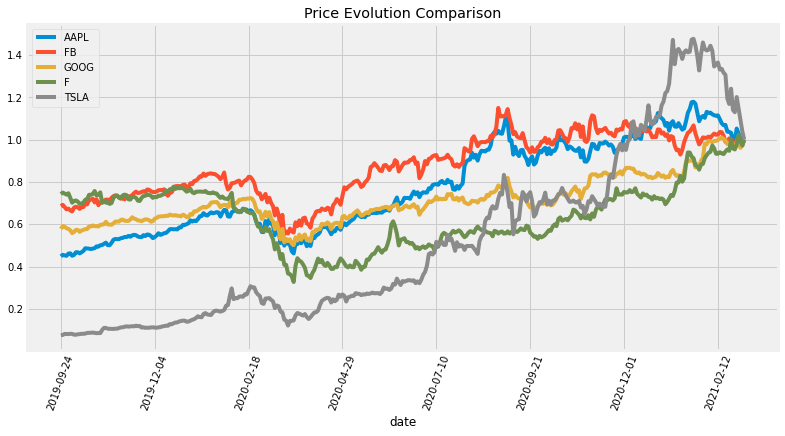

In [70]:
for i, col in enumerate(histpriceconcat.columns):
    histpriceconcat[col].plot()

plt.title('Price Evolution Comparison')

plt.xticks(rotation=70)
plt.legend(histpriceconcat.columns)

#Saving the graph into a JPG file
plt.savefig('foo1.png', bbox_inches='tight')